In [2]:
import os
import torch
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import color_palette
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Literal

In [3]:
os.chdir('..') # change working directory to root

In [4]:
from agents.d3qn import D3QN
from agents.implicit_q_learning import ImplicitQLearning
from mdp.trauma_icu_resuscitation.state_spaces.discrete import Components as StateSpaceComponents
from utilities import trauma_icu_resuscitation_funcs
from utilities.implicit_qlearning_dataset import ImplicitQLearningDataset

/Users/larry/anaconda3/envs/ope_310_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mlflow_base_path = '<path_to_mlruns>/mlruns'
mlflow.set_tracking_uri(mlflow_base_path)
agent_run_ids = {
    'd3qn': 'ef95ccf2eeca4a2a8e8fb66328c3ba2c',
    'iql': 'f32de422093a42c7b5966c52a71aae80'
}

In [6]:
def compute_action_counts(run_id_dict: Dict[str, str], n_splits: int = 10, action_type: Literal['discrete', 'binary'] = 'discrete', batch_size: int = 32, aggregate_cts: bool = True) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor]:
    num_actions = 12 if action_type == 'discrete' else 8
    actual_action_cts = torch.zeros(n_splits, num_actions, dtype=torch.long)
    d3qn_action_cts = torch.zeros(n_splits, num_actions, dtype=torch.long)
    iql_action_cts = torch.zeros(n_splits, num_actions, dtype=torch.long)
    for split in tqdm(range(n_splits), desc='processing splits', unit=' split'):
        # load data
        (
            (_, _, _, _, _, _),
            (_, _, _, _, _, _),
            (test_states, test_actions, test_rewards, test_dones, test_next_states, _)
        ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'iql', action_type)
        # flatten actions for D3QN and IQL
        match action_type:
            case 'discrete':
                test_actions = trauma_icu_resuscitation_funcs.flatten_discrete_actions(test_actions)
            case 'binary':
                test_actions = trauma_icu_resuscitation_funcs.flatten_binary_actions(test_actions)
            case _:
                raise ValueError(f'Invalid action type: {action_type}')
        test_dataset = ImplicitQLearningDataset(test_states.float(), test_actions, test_next_states.float(), test_rewards, test_dones)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        d3qn = D3QN(state_dim=len(StateSpaceComponents), action_dim=1,
                    hidden_dim=128, reward_max=1.0,
                    gamma=0.99, tau=5e-3, lr=1e-4, buffer_size=len(test_dataset), per_alpha=0.6,
                    per_beta=0.9, per_eps=1e-2, reg_lambda=5.0, batch_size=batch_size, num_actions=num_actions)
        d3qn.load_model(f'runs:/{run_id_dict["d3qn"]}/final_d3qn_model_split_{split}')
        d3qn.eval()
        iql = ImplicitQLearning(state_dim=len(StateSpaceComponents), action_dim=1,
                                num_actions=num_actions, 
                                policy_hidden_dim=128,
                                critic_hidden_dim=128, 
                                expectile_val_hidden_dim=128, 
                                policy_lr=1e-4,
                                critic_lr=1e-4, expectile_val_lr=1e-4,
                                gamma=0.99, expectile=0.8, temperature=0.1,
                                clip_norm=1.0, tau=5e-3,
                                weight_decay=1e-4)
        iql.load_model(f'runs:/{run_id_dict["iql"]}/final_iql_model_split_{split}')
        iql.eval()
        for states, actions, _, _, _ in test_dataloader:
            unique_actions, cts = actions.squeeze().unique(return_counts=True)
            actual_action_cts[split, unique_actions] += cts
            d3qn_actions, probs = d3qn.get_best_action(states)
            unique_actions, cts = d3qn_actions.action.squeeze().unique(return_counts=True)
            d3qn_action_cts[split, unique_actions] += cts
            iql_actions, probs = iql.get_best_action(states)
            unique_actions, cts = iql_actions.action.squeeze().unique(return_counts=True)
            iql_action_cts[split, unique_actions] += cts
    if aggregate_cts:
        actual_action_cts = actual_action_cts.sum(0)
        d3qn_action_cts = d3qn_action_cts.sum(0)
        iql_action_cts = iql_action_cts.sum(0)
    return actual_action_cts, d3qn_action_cts, iql_action_cts

In [7]:
behavior_policy_action_cts, d3qn_policy_action_cts, iql_policy_action_cts = compute_action_counts(agent_run_ids)

Data Split: 100%|██████████| 3/3 [01:57<00:00, 39.09s/ split]
2025/02/28 20:11:59 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 20:11:59 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 20:12:00 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 20:12:00 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 20:12:00 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 20:12:00 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
Data Split: 100%|██████████| 3/3 [00:24<00:00,  8.24s/ split]
2025/02/28 20:12:26 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTo

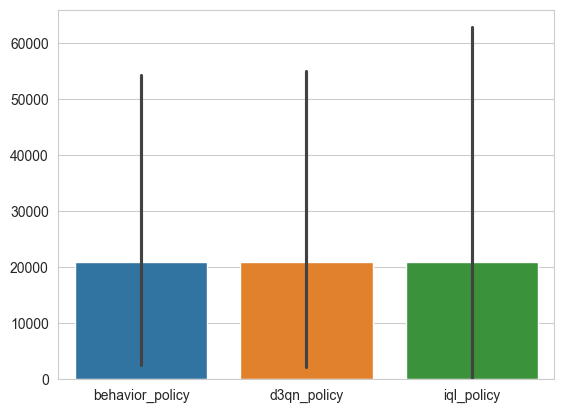

In [8]:
ax = sns.barplot({
    'behavior_policy': behavior_policy_action_cts.numpy(),
    'd3qn_policy': d3qn_policy_action_cts.numpy(),
    'iql_policy': iql_policy_action_cts.numpy()
})
plt.show()

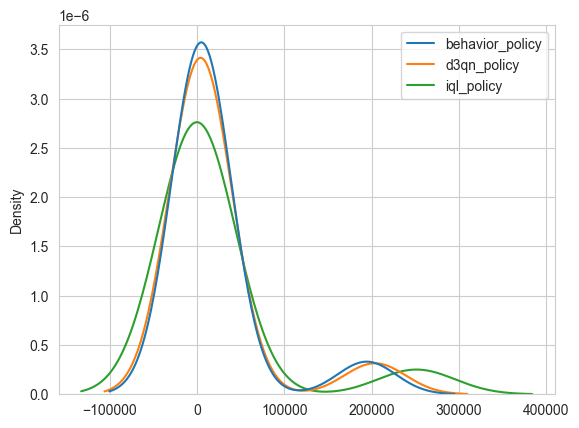

In [9]:
sns.kdeplot({
    'behavior_policy': behavior_policy_action_cts.numpy(),
    'd3qn_policy': d3qn_policy_action_cts.numpy(),
    'iql_policy': iql_policy_action_cts.numpy()
})
plt.show()

<Axes: ylabel='Count'>

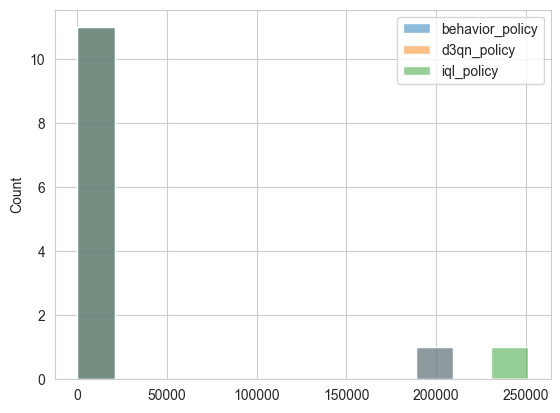

In [10]:
sns.histplot({
    'behavior_policy': behavior_policy_action_cts.numpy(),
    'd3qn_policy': d3qn_policy_action_cts.numpy(),
    'iql_policy': iql_policy_action_cts.numpy()
}, bins=12) #np.unique(behavior_policy_action_cts))

In [253]:
unflattened_action_map = trauma_icu_resuscitation_funcs.unflatten_discrete_actions(torch.arange(12).unsqueeze(-1))

In [254]:
indiv_behavior_action_cts = torch.zeros(3, 3)
indiv_d3qn_action_cts = torch.zeros(3, 3)
indiv_iql_action_cts = torch.zeros(3, 3)
for action_ct_lbl, action_cts, indiv_cts in (('behavior', behavior_policy_action_cts, indiv_behavior_action_cts),
                                             ('d3qn', d3qn_policy_action_cts, indiv_d3qn_action_cts),
                                             ('iql', iql_policy_action_cts, indiv_iql_action_cts)):
    for act_idx in range(action_cts.size(0)):
        action = unflattened_action_map[act_idx].clone()
        indiv_cts[0, action[0]] += action_cts[act_idx]
        indiv_cts[1, action[1]] += action_cts[act_idx]
        indiv_cts[2, action[2]] += action_cts[act_idx]

In [255]:
for i in range(3):
    indiv_behavior_action_cts[i] /= indiv_behavior_action_cts[i].sum()
    indiv_iql_action_cts[i] /= indiv_iql_action_cts[i].sum()
    indiv_d3qn_action_cts[i] /= indiv_d3qn_action_cts[i].sum()

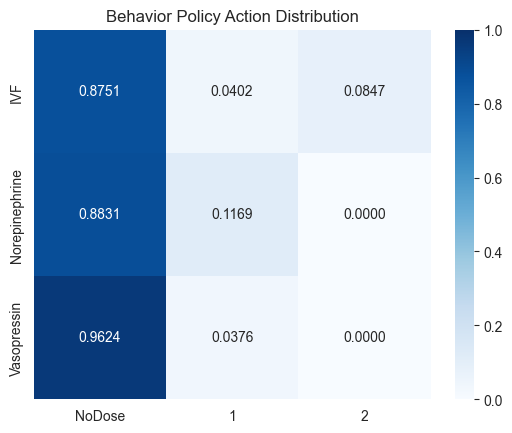

In [285]:
ax = sns.heatmap(indiv_behavior_action_cts.numpy(), vmin=0.0, vmax=1.0, cmap='Blues', annot=True, fmt='.4f')
ax.set_yticklabels(['IVF', 'Norepinephrine', 'Vasopressin'])
ax.set_xticklabels(['NoDose', '1', '2'])
ax.set_title('Behavior Policy Action Distribution')
plt.show()

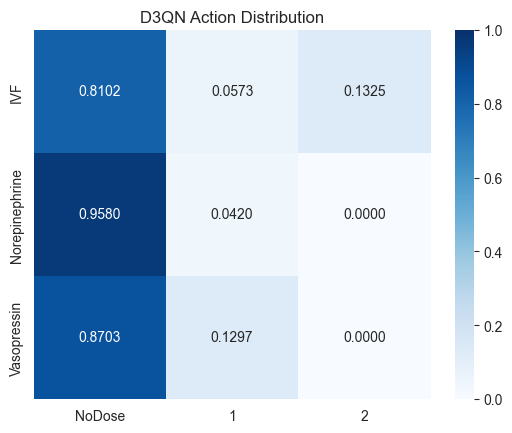

In [286]:
ax = sns.heatmap(indiv_d3qn_action_cts.numpy(), vmin=0.0, vmax=1.0, cmap='Blues', annot=True, fmt='.4f')
ax.set_yticklabels(['IVF', 'Norepinephrine', 'Vasopressin'])
ax.set_xticklabels(['NoDose', '1', '2'])
ax.set_title('D3QN Action Distribution')
plt.show()

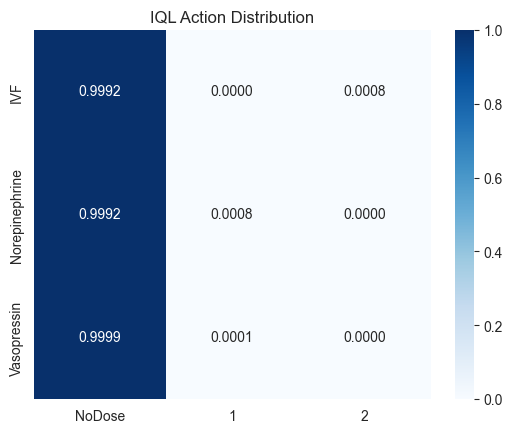

In [287]:
ax = sns.heatmap(indiv_iql_action_cts.numpy(), vmin=0.0, vmax=1.0, cmap='Blues', annot=True, fmt='.4f')
ax.set_yticklabels(['IVF', 'Norepinephrine', 'Vasopressin'])
ax.set_xticklabels(['NoDose', '1', '2'])
ax.set_title('IQL Action Distribution')
plt.show()

In [259]:
behavior_policy_action_split_cts, d3qn_policy_action_split_cts, iql_policy_action_split_cts = compute_action_counts(agent_run_ids, aggregate_cts=False)

Data Split: 100%|██████████| 3/3 [00:21<00:00,  7.07s/ split]
2025/02/28 21:42:49 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:42:49 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:42:49 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:42:49 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:42:49 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:42:49 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
Data Split: 100%|██████████| 3/3 [00:27<00:00,  9.20s/ split]
2025/02/28 21:43:18 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTo

In [260]:
assert torch.allclose(behavior_policy_action_split_cts.sum(0), behavior_policy_action_cts)
assert torch.allclose(d3qn_policy_action_split_cts.sum(0), d3qn_policy_action_cts)
assert torch.allclose(iql_policy_action_split_cts.sum(0), iql_policy_action_cts)

In [261]:
# NOTE: computing the standard deviations for the heatmaps above
indiv_behavior_action_split_cts_std = torch.zeros(10, 3, 3)
indiv_d3qn_action_split_cts_std = torch.zeros(10, 3, 3)
indiv_iql_action_split_cts_std = torch.zeros(10, 3, 3)
for action_ct_lbl, action_cts, indiv_cts in (('behavior', behavior_policy_action_split_cts, indiv_behavior_action_split_cts_std),
                                             ('d3qn', d3qn_policy_action_split_cts, indiv_d3qn_action_split_cts_std),
                                             ('iql', iql_policy_action_split_cts, indiv_iql_action_split_cts_std)):
    for split in range(10):
        #unique_actions = set()
        for act_idx in range(action_cts.size(1)):
            action = unflattened_action_map[act_idx].clone()
            #unique_actions.add(action[0].item())
            indiv_cts[split, 0, action[0]] += action_cts[split, act_idx]
            indiv_cts[split, 1, action[1]] += action_cts[split, act_idx]
            indiv_cts[split, 2, action[2]] += action_cts[split, act_idx]
        #print(unique_actions)
for split in range(10):
    for i in range(3):
        indiv_behavior_action_split_cts_std[split, i] /= indiv_behavior_action_split_cts_std[split, i].sum()
        indiv_iql_action_split_cts_std[split, i] /= indiv_iql_action_split_cts_std[split, i].sum()
        indiv_d3qn_action_split_cts_std[split, i] /= indiv_d3qn_action_split_cts_std[split, i].sum()
behavior_split_stds_std = torch.zeros(3, 3)
d3qn_split_stds_std = torch.zeros(3, 3)
iql_split_stds_std = torch.zeros(3, 3)
for i in range(3):
    for j in range(3):
        behavior_split_stds_std[i, j] = indiv_behavior_action_split_cts_std[:, i, j].std()
        d3qn_split_stds_std[i, j] = indiv_d3qn_action_split_cts_std[:, i, j].std()
        iql_split_stds_std[i, j] = indiv_iql_action_split_cts_std[:, i, j].std()

{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}


In [262]:
indiv_behavior_action_cts

tensor([[0.8751, 0.0402, 0.0847],
        [0.8831, 0.1169, 0.0000],
        [0.9624, 0.0376, 0.0000]])

In [263]:
behavior_split_stds_std

tensor([[0.0026, 0.0025, 0.0018],
        [0.0115, 0.0115, 0.0000],
        [0.0031, 0.0031, 0.0000]])

In [264]:
d3qn_split_stds_std

tensor([[0.1116, 0.0700, 0.0808],
        [0.0569, 0.0569, 0.0000],
        [0.1143, 0.1143, 0.0000]])

In [265]:
iql_split_stds_std

tensor([[0.0004, 0.0000, 0.0004],
        [0.0007, 0.0007, 0.0000],
        [0.0001, 0.0001, 0.0000]])

In [266]:
# NOTE: combining IVF actions 1 and 2 for McNemar's test (and for the abstract)
indiv_behavior_action_split_cts = torch.zeros(10, 3, 2)
indiv_d3qn_action_split_cts = torch.zeros(10, 3, 2)
indiv_iql_action_split_cts = torch.zeros(10, 3, 2)
for action_ct_lbl, action_cts, indiv_cts in (('behavior', behavior_policy_action_split_cts, indiv_behavior_action_split_cts),
                                             ('d3qn', d3qn_policy_action_split_cts, indiv_d3qn_action_split_cts),
                                             ('iql', iql_policy_action_split_cts, indiv_iql_action_split_cts)):
    for split in range(10):
        #unique_actions = set()
        for act_idx in range(action_cts.size(1)):
            action = unflattened_action_map[act_idx].clone()
            #unique_actions.add(action[0].item())
            if action[0] > 1:
                action[0] = 1
            indiv_cts[split, 0, action[0]] += action_cts[split, act_idx]
            indiv_cts[split, 1, action[1]] += action_cts[split, act_idx]
            indiv_cts[split, 2, action[2]] += action_cts[split, act_idx]
        #print(unique_actions)
for split in range(10):
    for i in range(3):
        indiv_behavior_action_split_cts[split, i] /= indiv_behavior_action_split_cts[split, i].sum()
        indiv_iql_action_split_cts[split, i] /= indiv_iql_action_split_cts[split, i].sum()
        indiv_d3qn_action_split_cts[split, i] /= indiv_d3qn_action_split_cts[split, i].sum()

{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}


In [267]:
indiv_behavior_action_split_cts.shape

torch.Size([10, 3, 2])

In [268]:
behavior_split_stds = torch.zeros(3, 2)
d3qn_split_stds = torch.zeros(3, 2)
iql_split_stds = torch.zeros(3, 2)
for i in range(3):
    for j in range(2):
        behavior_split_stds[i, j] = indiv_behavior_action_split_cts[:, i, j].std()
        d3qn_split_stds[i, j] = indiv_d3qn_action_split_cts[:, i, j].std()
        iql_split_stds[i, j] = indiv_iql_action_split_cts[:, i, j].std()

In [269]:
behavior_split_stds

tensor([[0.0026, 0.0026],
        [0.0115, 0.0115],
        [0.0031, 0.0031]])

In [270]:
d3qn_split_stds

tensor([[0.1116, 0.1116],
        [0.0569, 0.0569],
        [0.1143, 0.1143]])

In [271]:
iql_split_stds

tensor([[0.0004, 0.0004],
        [0.0007, 0.0007],
        [0.0001, 0.0001]])

In [272]:
def run_mcnemar(run_id_dict: Dict[str, str], unflattened_action_map_: torch.LongTensor, n_splits: int = 10, action_type: Literal['discrete', 'binary'] = 'discrete', batch_size: int = 32, aggregate_cts: bool = True) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor]:
    num_actions = 12 if action_type == 'discrete' else 8
    # NOTE: 0, 0 is NoDose, 1, 1 is Dose, Dose
    ivf_cts = torch.zeros(n_splits, 2, 2, dtype=torch.long)
    nor_cts = torch.zeros(n_splits, 2, 2, dtype=torch.long)
    vaso_cts = torch.zeros(n_splits, 2, 2, dtype=torch.long)
    for split in tqdm(range(n_splits), desc='processing splits', unit=' split'):
        # load data
        (
            (_, _, _, _, _, _),
            (_, _, _, _, _, _),
            (test_states, test_actions, test_rewards, test_dones, test_next_states, _)
        ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'iql', action_type)
        # flatten actions for D3QN and IQL
        match action_type:
            case 'discrete':
                test_actions = trauma_icu_resuscitation_funcs.flatten_discrete_actions(test_actions)
            case 'binary':
                test_actions = trauma_icu_resuscitation_funcs.flatten_binary_actions(test_actions)
            case _:
                raise ValueError(f'Invalid action type: {action_type}')
        test_dataset = ImplicitQLearningDataset(test_states.float(), test_actions, test_next_states.float(), test_rewards, test_dones)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        d3qn = D3QN(state_dim=len(StateSpaceComponents), action_dim=1,
                    hidden_dim=128, reward_max=1.0,
                    gamma=0.99, tau=5e-3, lr=1e-4, buffer_size=len(test_dataset), per_alpha=0.6,
                    per_beta=0.9, per_eps=1e-2, reg_lambda=5.0, batch_size=batch_size, num_actions=num_actions)
        d3qn.load_model(f'runs:/{run_id_dict["d3qn"]}/final_d3qn_model_split_{split}')
        d3qn.eval()
        # iql = ImplicitQLearning(state_dim=len(StateSpaceComponents), action_dim=1,
        #                         num_actions=num_actions,
        #                         policy_hidden_dim=128,
        #                         critic_hidden_dim=128,
        #                         expectile_val_hidden_dim=128,
        #                         policy_lr=1e-4,
        #                         critic_lr=1e-4, expectile_val_lr=1e-4,
        #                         gamma=0.99, expectile=0.8, temperature=0.1,
        #                         clip_norm=1.0, tau=5e-3,
        #                         weight_decay=1e-4)
        # iql.load_model(f'runs:/{run_id_dict["iql"]}/final_iql_model_split_{split}')
        # iql.eval()
        for states, actions, _, _, _ in test_dataloader:
            # NOTE: we are combining IVF actions 1 and 2 for McNemar's test (and for the abstract)
            unflattened_actions = unflattened_action_map_[actions.squeeze()].clone()
            unflattened_actions[:, 0] = torch.where(unflattened_actions[:, 0] == 2, 1, unflattened_actions[:, 0])
            d3qn_actions, probs = d3qn.get_best_action(states)
            unflattened_d3qn_actions = unflattened_action_map_[d3qn_actions.action.squeeze()].clone()
            unflattened_d3qn_actions[:, 0] = torch.where(unflattened_d3qn_actions[:, 0] == 2, 1, unflattened_d3qn_actions[:, 0])
            for actual_actions_, d3qn_actions_, cts_ in zip((unflattened_actions[:, 0],
                                                             unflattened_actions[:, 1],
                                                             unflattened_actions[:, 2]),
                                                            (unflattened_d3qn_actions[:, 0],
                                                             unflattened_d3qn_actions[:, 1],
                                                             unflattened_d3qn_actions[:, 2]),
                                                            (ivf_cts, nor_cts, vaso_cts)):
                # this is the slower way - we could use masks to speed this up
                for actual_action, d3qn_action in zip(actual_actions_, d3qn_actions_):
                    cts_[split, actual_action, d3qn_action] += 1

    if aggregate_cts:
        ivf_cts = ivf_cts.sum(0)
        nor_cts = nor_cts.sum(0)
        vaso_cts = vaso_cts.sum(0)
    return ivf_cts, nor_cts, vaso_cts

In [273]:
ivf_cts, nor_cts, vaso_cts = run_mcnemar(agent_run_ids, unflattened_action_map)

Data Split: 100%|██████████| 3/3 [00:13<00:00,  4.67s/ split]
2025/02/28 21:45:26 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:45:26 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
Data Split: 100%|██████████| 3/3 [00:07<00:00,  2.33s/ split]
2025/02/28 21:45:35 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:45:35 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
Data Split: 100%|██████████| 3/3 [00:07<00:00,  2.47s/ split]
2025/02/28 21:45:44 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
2025/02/28 21:45:44 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.2.2'
Data Split: 100%|██████████| 3/3 [00:07<00:00,

In [274]:
ivf_cts

tensor([[177833,  42521],
        [ 26190,   5260]])

In [275]:
nor_cts

tensor([[211997,  10362],
        [ 29224,    221]])

In [276]:
vaso_cts

tensor([[210522,  31822],
        [  8612,    848]])

In [277]:
from statsmodels.stats.contingency_tables import mcnemar
ivf_mcnemar_result = mcnemar(ivf_cts.numpy(), exact=False)
nor_mcnemar_result = mcnemar(nor_cts.numpy(), exact=False)
vaso_mcnemar_result = mcnemar(vaso_cts.numpy(), exact=False)
print(f'IVF McNemar: Statistic={ivf_mcnemar_result.statistic}, p-value={ivf_mcnemar_result.pvalue}')
print(f'Norepinephrine McNemar: Statistic={nor_mcnemar_result.statistic}, p-value={nor_mcnemar_result.pvalue}')
print(f'Vasopressin McNemar: Statistic={vaso_mcnemar_result.statistic}, p-value={vaso_mcnemar_result.pvalue}')

IVF McNemar: Statistic=3881.021961549097, p-value=0.0
Norepinephrine McNemar: Statistic=8986.442707017632, p-value=0.0
Vasopressin McNemar: Statistic=13321.89941633279, p-value=0.0


In [278]:
(ivf_cts[1, 0] - ivf_cts[0, 1]) ** 2 / (ivf_cts[1, 0] + ivf_cts[0, 1])

tensor(3881.4973)

In [279]:
(nor_cts[1, 0] - nor_cts[0, 1]) ** 2 / (nor_cts[1, 0] + nor_cts[0, 1])

tensor(8987.3955)

In [280]:
(vaso_cts[1, 0] - vaso_cts[0, 1]) ** 2 / (vaso_cts[1, 0] + vaso_cts[0, 1])

tensor(13323.0479)